In [ ]:
# TensorFlow Workflow, End-to-End (Supply Chain Edition)

**Goal:** Demonstrate a practical flow for using TensorFlow/Keras in supply chain analytics:
1) set up & seed  
2) create/ingest data  
3) build `tf.data` pipelines  
4) model design (regression + classification)  
5) train with callbacks (ES/CKPT/TensorBoard)  
6) evaluate & visualize  
7) save / load / (optional) export to TFLite

> Use this as a repeatable template for future projects.


In [1]:
# =========================
# 0. Setup & Environment
# =========================
# If needed (uncomment for fresh envs):
# !pip install -U pip
# !pip install -U tensorflow pandas numpy scikit-learn matplotlib

import os, json, math, time, pathlib, itertools, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make runs reproducible (as much as practical)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.18.0


In [ ]:
## 1) Synthetic Supply Chain Data
We’ll build two small datasets:

**A. Demand regression**  
- Features: day-of-week, promo flag, price, seasonality.  
- Target: next-day demand.

**B. Stockout-risk classification**  
- Features: lead time, on-hand, daily demand, supplier score.  
- Target: 0/1 stockout risk (synthetic label).


In [5]:
# ===========================================
# 1A. Synthetic daily demand (regression)
# ===========================================
N = 5000
days = np.arange(N)

dow = (days % 7)                         # day of week (0..6)
season = 20*np.sin(2*np.pi*days/365.0)   # yearly-ish seasonality
promo = (np.random.rand(N) < 0.15).astype(int)  # 15% promo days
base_price = 10 + 2*np.sin(days/30.0)
price = base_price + np.random.normal(0, 0.5, size=N)

true_demand = (
    50
    + 5*(dow==5)                          # small weekend bump (Sat)
    + 12*promo                            # promo lifts demand
    + season
    - 1.2*(price - 10)                    # price sensitivity
)
noise = np.random.normal(0, 3.0, size=N)
demand = (true_demand + noise).clip(0)

# Predict next day's demand given today's features
df_reg = pd.DataFrame({
    "dow": dow,
    "promo": promo,
    "price": price,
    "season": season,
    "demand_t": demand
})
df_reg["demand_t_plus_1"] = df_reg["demand_t"].shift(-1)
df_reg = df_reg.dropna().reset_index(drop=True)

df_reg.head()


,dow,promo,price,season,demand_t,demand_t_plus_1
0,0,0,9.701513,0.000000,49.922136,52.740657
1,1,0,8.871502,0.344267,52.740657,47.811875
2,2,0,9.927124,0.688432,47.811875,49.803131
3,3,0,10.656404,1.032393,49.803131,50.137230
4,4,0,10.534692,1.376049,50.137230,56.618715


In [7]:
# ===========================================
# 1B. Synthetic stockout risk (classification)
# ===========================================
M = 6000
np.random.seed(SEED)
lead_time = np.random.randint(1, 30, size=M)             # days
on_hand   = np.random.randint(0, 1000, size=M)
daily_dmd = np.random.gamma(shape=3.0, scale=15.0, size=M)
supplier_score = np.random.uniform(0.5, 1.0, size=M)     # 0.5..1.0

# Simple heuristic to generate a label:
# High lead time + low on hand + high demand + low supplier score => stockout risk
risk_score = (
    0.04*lead_time
    + 0.002*(np.maximum(0, 300 - on_hand))
    + 0.002*daily_dmd
    + (1.0 - supplier_score)
)
prob = 1 / (1 + np.exp(- (risk_score - 1.2)))  # sigmoid transform
y = (np.random.rand(M) < prob).astype(int)

df_cls = pd.DataFrame({
    "lead_time": lead_time,
    "on_hand": on_hand,
    "daily_demand": daily_dmd,
    "supplier_score": supplier_score,
    "stockout_risk": y
})
df_cls.head()


,lead_time,on_hand,daily_demand,supplier_score,stockout_risk
0,7,684,120.325271,0.846170,0
1,20,81,59.661572,0.517166,1
2,29,833,41.521086,0.601777,1
3,15,332,127.253296,0.609335,1
4,11,556,17.017692,0.834663,0


In [ ]:
## 2) Train/Val/Test Split & `tf.data` Pipelines
Why `tf.data`? Efficient, shuffle/cache/prefetch, easy scaling.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------
# Regression split & scale
# -------------------------
Xr = df_reg[["dow", "promo", "price", "season", "demand_t"]].copy()
yr = df_reg["demand_t_plus_1"].values.astype(np.float32)

Xr_train, Xr_temp, yr_train, yr_temp = train_test_split(Xr, yr, test_size=0.3, random_state=SEED)
Xr_val, Xr_test, yr_val, yr_test   = train_test_split(Xr_temp, yr_temp, test_size=0.5, random_state=SEED)

scaler_r = StandardScaler()
Xr_train_sc = scaler_r.fit_transform(Xr_train)
Xr_val_sc   = scaler_r.transform(Xr_val)
Xr_test_sc  = scaler_r.transform(Xr_test)

# -------------------------
# Classification split & scale
# -------------------------
Xc = df_cls[["lead_time", "on_hand", "daily_demand", "supplier_score"]].copy()
yc = df_cls["stockout_risk"].values.astype(np.int32)

Xc_train, Xc_temp, yc_train, yc_temp = train_test_split(Xc, yc, test_size=0.3, random_state=SEED, stratify=yc)
Xc_val, Xc_test, yc_val, yc_test     = train_test_split(Xc_temp, yc_temp, test_size=0.5, random_state=SEED, stratify=yc_temp)

scaler_c = StandardScaler()
Xc_train_sc = scaler_c.fit_transform(Xc_train)
Xc_val_sc   = scaler_c.transform(Xc_val)
Xc_test_sc  = scaler_c.transform(Xc_test)

# -------------------------
# Build tf.data
# -------------------------
BATCH = 64
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

ds_r_train = make_ds(Xr_train_sc, yr_train, shuffle=True)
ds_r_val   = make_ds(Xr_val_sc,   yr_val,   shuffle=False)
ds_r_test  = make_ds(Xr_test_sc,  yr_test,  shuffle=False)

ds_c_train = make_ds(Xc_train_sc, yc_train, shuffle=True)
ds_c_val   = make_ds(Xc_val_sc,   yc_val,   shuffle=False)
ds_c_test  = make_ds(Xc_test_sc,  yc_test,  shuffle=False)


In [ ]:
## 3) Model Design with Keras
- **Regression:** MLP predicting next-day demand (MSE/MAE).  
- **Classification:** MLP predicting stockout risk (binary cross-entropy, AUC).


In [11]:
# ====================
# 3A. Regression model
# ====================
def build_regressor(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="reg_features")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, name="demand_next_day")(x)
    model = keras.Model(inputs, outputs, name="demand_regressor")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

reg_model = build_regressor(Xr_train_sc.shape[1])
reg_model.summary()


Model: "demand_regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reg_features (InputLayer)       │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ demand_next_day (Dense)         │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# =======================
# 3B. Classification model
# =======================
def build_classifier(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="clf_features")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="stockout_prob")(x)
    model = keras.Model(inputs, outputs, name="stockout_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="acc")]
    )
    return model

cls_model = build_classifier(Xc_train_sc.shape[1])
cls_model.summary()


Model: "stockout_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ clf_features (InputLayer)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stockout_prob (Dense)           │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,473 (37.00 KB)

 Trainable params: 9,217 (36.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
## 4) Training with Callbacks + TensorBoard
We’ll use:
- `EarlyStopping` to stop when val metric stops improving
- `ModelCheckpoint` to keep the best weights
- `TensorBoard` to inspect learning curves


In [15]:
# ======================
# 4. Callbacks & logging
# ======================
RUN_DIR = pathlib.Path("runs") / time.strftime("tf_%Y%m%d_%H%M%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)

ckpt_reg = keras.callbacks.ModelCheckpoint(
    filepath=str(RUN_DIR / "reg_best.keras"),
    monitor="val_mae",
    mode="min",
    save_best_only=True
)

ckpt_cls = keras.callbacks.ModelCheckpoint(
    filepath=str(RUN_DIR / "cls_best.keras"),
    monitor="val_auc",
    mode="max",
    save_best_only=True
)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

tb = keras.callbacks.TensorBoard(log_dir=str(RUN_DIR / "tb"), histogram_freq=1)

# ------------------
# Train Regression
# ------------------
hist_reg = reg_model.fit(
    ds_r_train,
    validation_data=ds_r_val,
    epochs=100,
    callbacks=[ckpt_reg, early, tb],
    verbose=2
)

# ------------------
# Train Classification
# ------------------
hist_cls = cls_model.fit(
    ds_c_train,
    validation_data=ds_c_val,
    epochs=100,
    callbacks=[ckpt_cls, early, tb],
    verbose=2
)


Epoch 1/100
55/55 - 7s - 122ms/step - loss: 2810.5244 - mae: 50.7068 - val_loss: 2428.0159 - val_mae: 46.9944
Epoch 2/100
55/55 - 1s - 10ms/step - loss: 1525.9714 - mae: 35.8979 - val_loss: 527.0377 - val_mae: 20.4143
Epoch 3/100
55/55 - 1s - 10ms/step - loss: 199.2165 - mae: 11.2609 - val_loss: 103.5401 - val_mae: 8.1563
Epoch 4/100
55/55 - 1s - 10ms/step - loss: 101.1899 - mae: 8.0311 - val_loss: 86.1815 - val_mae: 7.3638
Epoch 5/100
55/55 - 1s - 10ms/step - loss: 88.7250 - mae: 7.5414 - val_loss: 75.8048 - val_mae: 6.8744
Epoch 6/100
55/55 - 1s - 10ms/step - loss: 77.8595 - mae: 7.0470 - val_loss: 67.5102 - val_mae: 6.4548
Epoch 7/100
55/55 - 1s - 9ms/step - loss: 70.7338 - mae: 6.7212 - val_loss: 60.8705 - val_mae: 6.0935
Epoch 8/100
55/55 - 1s - 10ms/step - loss: 63.9981 - mae: 6.3574 - val_loss: 55.5878 - val_mae: 5.8726
Epoch 9/100
55/55 - 1s - 9ms/step - loss: 59.7424 - mae: 6.1251 - val_loss: 51.0922 - val_mae: 5.5451
Epoch 10/100
55/55 - 1s - 10ms/step - loss: 54.9584 - mae: 

In [ ]:
## 5) Visualize Learning Curves
Simple Matplotlib plots from `History` objects.


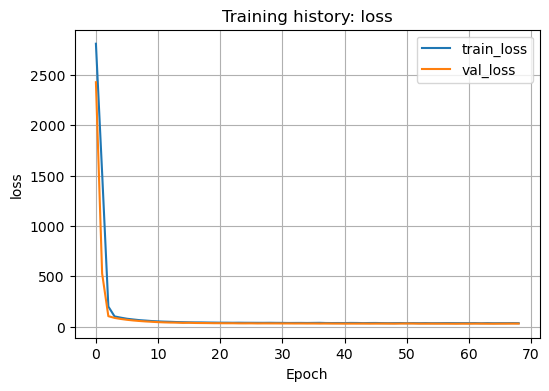

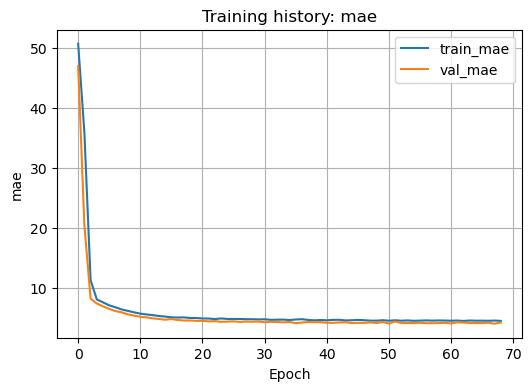

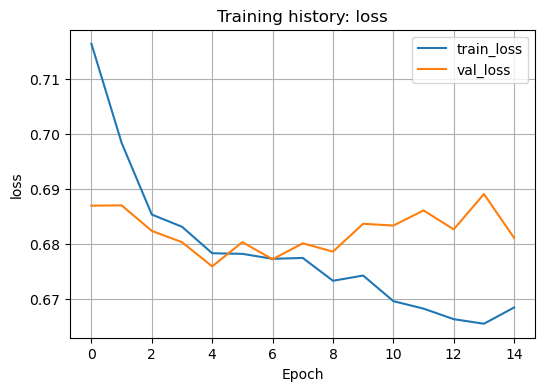

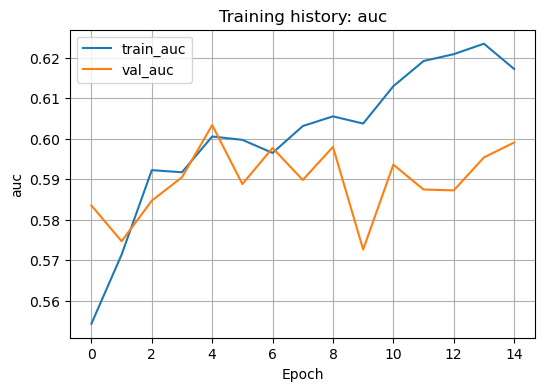

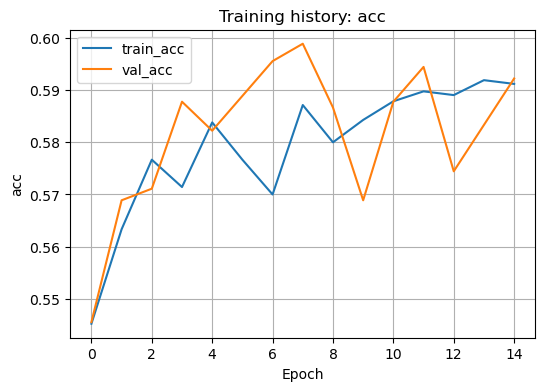

In [17]:
def plot_history(history, metrics=("loss",)):
    for m in metrics:
        plt.figure(figsize=(6,4))
        plt.plot(history.history[m], label=f"train_{m}")
        val_key = f"val_{m}"
        if val_key in history.history:
            plt.plot(history.history[val_key], label=f"val_{m}")
        plt.xlabel("Epoch")
        plt.ylabel(m)
        plt.title(f"Training history: {m}")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_history(hist_reg, metrics=("loss","mae"))
plot_history(hist_cls, metrics=("loss","auc","acc"))


In [ ]:
## 6) Evaluate on Test & Inspect Predictions


Regression test metrics: {'loss': 30.311965942382812, 'mae': 4.266079902648926}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


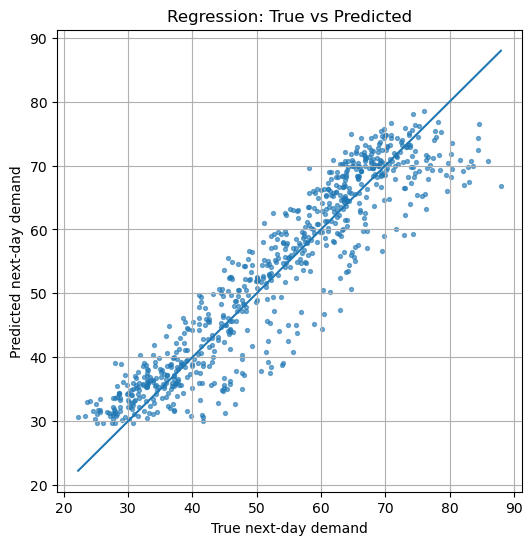

Classification test metrics: {'acc': 0.5455555319786072, 'auc': 0.5469698309898376, 'loss': 0.6861083507537842}
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


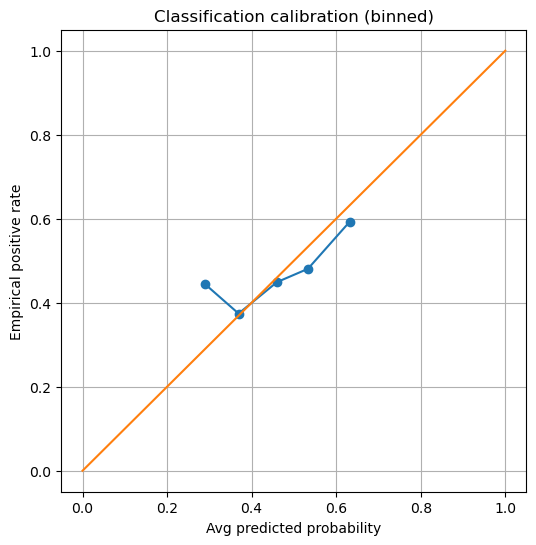

In [19]:
# -------------------------
# Regression metrics / plots
# -------------------------
test_eval_reg = reg_model.evaluate(ds_r_test, return_dict=True, verbose=0)
print("Regression test metrics:", test_eval_reg)

yhat_r = reg_model.predict(ds_r_test).ravel()
ytrue_r = np.concatenate([y for _, y in ds_r_test], axis=0)

plt.figure(figsize=(6,6))
plt.scatter(ytrue_r, yhat_r, s=8, alpha=0.6)
plt.xlabel("True next-day demand")
plt.ylabel("Predicted next-day demand")
plt.title("Regression: True vs Predicted")
lim_min, lim_max = min(ytrue_r.min(), yhat_r.min()), max(ytrue_r.max(), yhat_r.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max])
plt.grid(True)
plt.show()

# -------------------------
# Classification metrics / plots
# -------------------------
test_eval_cls = cls_model.evaluate(ds_c_test, return_dict=True, verbose=0)
print("Classification test metrics:", test_eval_cls)

yhat_c = cls_model.predict(ds_c_test).ravel()
ytrue_c = np.concatenate([y for _, y in ds_c_test], axis=0)

# Calibration-style plot: buckets of predicted prob vs. actual rate
bins = np.linspace(0, 1, 11)
digitized = np.digitize(yhat_c, bins) - 1
bucket_avg_pred = []
bucket_actual = []
for b in range(len(bins)-1):
    mask = digitized == b
    if np.any(mask):
        bucket_avg_pred.append(np.mean(yhat_c[mask]))
        bucket_actual.append(np.mean(ytrue_c[mask]))
plt.figure(figsize=(6,6))
plt.plot(bucket_avg_pred, bucket_actual, marker="o")
plt.plot([0,1],[0,1])
plt.xlabel("Avg predicted probability")
plt.ylabel("Empirical positive rate")
plt.title("Classification calibration (binned)")
plt.grid(True)
plt.show()


In [ ]:
# --------------------------
# Save best weights already via checkpoints; here save full models:
# --------------------------
SAVE_DIR = pathlib.Path("artifacts")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

reg_model_path = SAVE_DIR / "regressor_full.keras"
cls_model_path = SAVE_DIR / "classifier_full.keras"

reg_model.save(reg_model_path)
cls_model.save(cls_model_path)

# Load back:
reg_loaded = keras.models.load_model(reg_model_path)
cls_loaded = keras.models.load_model(cls_model_path)

print("Reloaded:", reg_loaded.name, cls_loaded.name)

# --------------------------
# Export to SavedModel (for inference servers) & TFLite (edge)
# --------------------------
savedmodel_dir = SAVE_DIR / "savedmodel_reg"
reg_loaded.export(savedmodel_dir)

# TFLite conversion (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(reg_loaded)
tflite_model = converter.convert()
(SAVE_DIR / "regressor.tflite").write_bytes(tflite_model)
print("TFLite size (KB):", len(tflite_model)/1024.0)
